# Lab 3: Sentiment Analysis with LSTMs using PyTorch

In this lab session, you'll implement an **RNN-based sentence classifier**. Plain old RNNs aren't very good at sentiment classification, so we will use PyTorch to implement a more advanced __Long Short Term Memory__ (LSTM) based sentiment classifier.


__Objectives__: In this lab session will learn the following:

- Word embedding representation
- Preprocessing data for recurrent archictures (sequence padding)
- Implementation of LSTM-based classifier



----

Remember from the theory that Recurrent Neural Networks apply over and over the same function (the recursive cell) to every token in the sequence. In a simplified version the next token is combined with the output of the previous _state_ (contains the information of what has been seen so far) into the recursive function, so that the whole sequence is represented in a single vector.

Figure below shows an unrolled LSTM archicture, in which input text sequence, once tokenized and obtained the word index, is represented by word embeddings. Embedding lookup layer takes a list of word indexes and returns a list word embeddings (low-dimensional dense vectors that represent words). These word embeddings are what actually fed to sentence encoder. Finally, the last output of the LSTM is fed to a fully connected Linear layer. As we'll learn, this is fairly straightforward to implement with PyTorch.


![](http://ixa2.si.ehu.es/~jibloleo/uc3m_dl4nlp/img/LSTM_sentiment.png)


Advantages of these types of architectures:

- We do not need to show the whole sequence to the model. Actually, each input token is processed independently and current state is kept in memory for the next step.
- We save memory as we share the weights for each time-step.

## 1. Loading the data
We'll use the same data used in previous session.

In [2]:
# Mount Drive files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# install libraries
!pip install tensorflow
!pip install datasets==2.17.1
# import load_dataset from dataset
from datasets import load_dataset
# set seed for replicability of results
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
from collections import Counter
import time
from torch.utils.data import DataLoader, TensorDataset

np.random.seed(2)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 16.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2023.10.0 which is incompatible.


In [4]:
# device - PyTorch requires explicit device management
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Note: In PyTorch, you need to explicitly move tensors and models to the device using .to(device)
# This is different from Keras/TensorFlow where device management is more automatic

Using device: cuda


In [5]:
from sklearn.utils import shuffle

# custom data loader path CHANGE home TO YOUR DIRECTORY
home = '/content/drive/MyDrive/Colab Notebooks/dl4nlp_summer_labs/'
sst_home = home + 'utils/sst_custom_loader.py'
# load data with load_dataset and our custom data loader script
data = load_dataset(sst_home)
training_set = pd.DataFrame(data['train'])
dev_set = pd.DataFrame(data['validation'])
test_set = pd.DataFrame(data['test'])

# Shuffle dataset
training_set = shuffle(training_set)
dev_set = shuffle(dev_set)
test_set = shuffle(test_set)

# Obtain text and label vectors
train_texts = training_set.text
train_labels = training_set.label

dev_texts = dev_set.text
dev_labels = dev_set.label

test_texts = test_set.text
test_labels = test_set.label


print('Training size: {}'.format(len(training_set)))
print('Dev size: {}'.format(len(dev_set)))
print('Test size: {}'.format(len(test_set)))

/usr/local/lib/python3.12/dist-packages/datasets/load.py:923: FutureWarning: The repository for sst_custom_loader contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at /content/drive/MyDrive/Colab Notebooks/dl4nlp_summer_labs/utils/sst_custom_loader.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Training size: 6920
Dev size: 872
Test size: 1821


## 2. Preprocessing: Tokenization, Sequence Padding

When process data to feed a recurrent archicture, we need to do it differently compared to what we have seen so far. Unrolling each sequence one by one would take for ever, as we would lost the hability for parallelization. In deep learning framework learning is done by mini-batching the training data, which requires having same sequence length for all the input examples in the mini-batch.

In order to do mini-batch (there are more sophisticated alternatives):
- Choose a single unrolling constant N (e.g. max sequence length)
- Pad last words with zeros (shifting left)


There are more sophisticated alternivative like shuffling examples by sentence length (set N to max. length in mini-batch).

In the following chunk of code, we will implement our own tokenization and padding functions for PyTorch, as PyTorch doesn't have built-in text preprocessing utilities like Keras.


In [6]:
import re
from collections import Counter
import torch

class TorchTokenizer:
    def __init__(self, num_words=10000, oov_token="<unk>"):
        self.num_words = num_words
        self.oov_token = oov_token
        self.word_index = {oov_token: 1}  # reserve 0 for padding
        self.index_word = {1: oov_token}
        self.word_counts = Counter()

    def fit_on_texts(self, texts):
        for text in texts:
            # simple tokenizer: alphanumeric word boundaries
            for w in re.findall(r"\b\w+\b", str(text).lower()):
                self.word_counts[w] += 1
        # most common words (excluding padding)
        most_common = self.word_counts.most_common(self.num_words - 1)
        # start from 2 because 0=pas, 1=oov
        for idx, (word, _) in enumerate(most_common, start=2):
            self.word_index[word] = idx
            self.index_word[idx] = word

    def texts_to_sequences(self, texts):
        sequences = []
        for text in texts:
            seq = []
            for w in re.findall(r"\b\w+\b", str(text).lower()):
                idx = self.word_index.get(w, self.word_index[self.oov_token])
                # keep indices in range [0, num_words-1]
                if idx < self.num_words:
                    seq.append(idx)
                else:
                    seq.append(self.word_index[self.oov_token])
            sequences.append(seq)
        return sequences


def pad_sequences(sequences, maxlen):
    batch_size = len(sequences)
    x = torch.zeros((batch_size, maxlen), dtype=torch.long)
    for i, seq in enumerate(sequences):
        if len(seq) == 0:
            continue
        if len(seq) <= maxlen:
            x[i, :len(seq)] = torch.tensor(seq, dtype=torch.long)
        else:
            x[i, :] = torch.tensor(seq[:maxlen], dtype=torch.long)
    return x

def get_data_loaders(batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    return train_loader, dev_loader, test_loader

Shape of the training set (nb_examples, seq_len): torch.Size([6920, 40])
Shape of the validation set (nb_examples, seq_len): torch.Size([872, 40])
Shape of the test set (nb_examples, seq_len): torch.Size([1821, 40])

TEXT: This rush to profits has created a predictably efficient piece of business notable largely for its overwhelming creepiness , for an eagerness to create images you wish you had n't seen , which , in this day and age , is of course the point .
PADDED: tensor([  17, 1827,    6, 7190,   29,  935,    3, 1828, 4930,  249,    5, 1200,
        2979, 1201,   19,   20, 2980, 4931,   19,   18, 7191,    6,  874,  536,
          21, 1010,   21,  207,   24,   22,  200,   79,   11,   17,  280,    4,
         342,    7,    5, 1317])

TEXT: Takes a clunky TV-movie approach to detailing a chapter in the life of the celebrated Irish playwright , poet and drinker .
PADDED: tensor([ 234,    3, 3709,  383,   16,  763,    6, 4932,    3, 7192,   11,    2,
          80,    5,    2, 4933, 248

In [ ]:
# hyperparams for the tokenizer
max_words = 10000
max_seq = 40

# Build tokenizer on training texts only
tokenizer = TorchTokenizer(num_words=max_words, oov_token="<unk>")
tokenizer.fit_on_texts(train_texts)

# Convert to sequences
train_sequences = tokenizer.texts_to_sequences(train_texts)
dev_sequences = tokenizer.texts_to_sequences(dev_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

# Pad
x_train = pad_sequences(train_sequences, maxlen=max_seq)
x_dev = pad_sequences(dev_sequences, maxlen=max_seq)
x_test = pad_sequences(test_sequences, maxlen=max_seq)

# Labels
y_train = torch.tensor(train_labels, dtype=torch.float32).unsqueeze(1)
y_dev = torch.tensor(dev_labels, dtype=torch.float32).unsqueeze(1)
y_test = torch.tensor(test_labels, dtype=torch.float32).unsqueeze(1)

# Create datasets using PyTorch's TensorDataset
train_dataset = TensorDataset(x_train, y_train)
dev_dataset = TensorDataset(x_dev, y_dev)
test_dataset = TensorDataset(x_test, y_test)

print('Shape of the training set (nb_examples, seq_len):', x_train.shape)
print('Shape of the validation set (nb_examples, seq_len):', x_dev.shape)
print('Shape of the test set (nb_examples, seq_len):', x_test.shape)

# Print some examples
print()
print('TEXT: {}\nPADDED: {}'.format(train_texts.iloc[0], x_train[0]))
print()
print('TEXT: {}\nPADDED: {}'.format(train_texts.iloc[1], x_train[1]))

## 3. First LSTM-based classifier

In this section we will build our first LSTM-based classifier in PyTorch. Note that the LSTM layer in PyTorch takes inputs of shape ```[batch_size, sequence_length, input_features]```, and it is the reason of why we perform padding when preprocessed the data in the previous section.

Note that after the padding our data still is 2D tensor of shape ```[batch_size, sequence_length]```. Transformation from 2D to 3D is done with ```nn.Embedding``` layer in PyTorch, which takes the 2D tensor (```[batch_size, sequence_length]```). ```sequence_length``` is an entry of a list of word indexes, where all the entries in the batch have the same length. (That's why we padded with zeros the shorter sequences).

```nn.Embedding``` layer returns a tensor of shape ```[batch_size, sequence_length, embedding_size]```. This can be understood like adding the corresponding embedded vector to each word in the sequence. The layer can be initialized at random and learn with backpropagation, or use precomputed embedding vectors like _Word2vec_ or _GloVe_.

Once our data is represented with 3D tensors we can use directly the ```nn.LSTM``` layer. For this task we will combine three PyTorch layers in this specific order:

- ```nn.Embedding``` layer: it will transform the data from 2D to 3D by adding associated embeddings to words in the sequences. In the constructor we need to specify two arguments:
   - num_embeddings: int > 0. Size of the vocabulary, i.e. maximum integer index + 1.
   - embedding_dim: int >= 0. Dimension of the dense embedding.
   
- ```nn.LSTM``` layer: It will encode the input sequences and return output tensor. For the LSTM we need to specify the number of units of the LSTM:
   - hidden_size: Positive integer, dimensionality of the output space.
   
- ```nn.Linear```: It will take the output of the LSTM as input and perform the classification.

In [7]:
@torch.no_grad()
def evaluate(model, data_loader):

    model.eval()

    total_loss = 0
    correct = 0
    total = 0

    for xb, yb in data_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        # forward pass
        probs, loss = model(xb, yb)
        total_loss += loss.item() * xb.size(0)

        preds = (probs > 0.5).float()
        correct += (preds == yb).sum().item()
        total += yb.size(0)

    loss = total_loss / total
    acc = correct / total
    model.train()

    return loss, acc


def train_loop(model, optimizer, epochs):

    # train mode for model
    model.train()

    # trackers
    history = {"loss": [], "dev_loss": [], "acc": [], "dev_acc": []}
    t0 = time.time()
    t_prev = t0

    # loop
    for epoch in range(epochs):
        total_loss, correct, total = 0, 0, 0
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            # zero gradients
            optimizer.zero_grad()

            # forward pass
            probs, loss = model(xb, yb)

            # backward pass
            loss.backward()

            # optimizer step
            optimizer.step()

            # compute metrics
            total_loss += loss.item() * xb.size(0)
            total += yb.size(0)
            with torch.no_grad():
                preds = (probs > 0.5).float()
                correct += (preds == yb).sum().item()

        loss = total_loss / total
        acc = correct / total

        # Evaluation
        dev_loss, dev_acc = evaluate(model, dev_loader)

        # Store info
        history["loss"].append(loss)
        history["dev_loss"].append(dev_loss)
        history["acc"].append(acc)
        history["dev_acc"].append(dev_acc)

        # Logging
        t = time.time()
        print(
            f"Epoch {epoch+1}/{epochs} - "
            f"Train loss: {loss:.4f} - "
            f"Train acc: {acc:.4f} - "
            f"Dev loss: {dev_loss:.4f} - "
            f"Dev acc: {dev_acc:.4f} - "
            f"Time: {(t - t_prev)*1000:.2f}ms"
        )

        # Updates
        t_prev = t

    return history

# Plot curves and evaluate on test set
import matplotlib.pyplot as plt

def plot_history(history):
    plt.plot(history['loss'])
    plt.plot(history['dev_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'dev'], loc='upper left')
    plt.show()

    plt.plot(history['acc'])
    plt.plot(history['dev_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'dev'], loc='upper left')
    plt.show()

In [8]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes=1, pad_idx=0):
        super().__init__()
        self.pad_idx = pad_idx
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=self.pad_idx)
        self.lstm = nn.LSTM(input_size=embedding_dim,
                            hidden_size=hidden_dim,
                            batch_first=True)
        self.classifier = nn.Linear(hidden_dim, num_classes)
        self.sigmoid = nn.Sigmoid()
        self.criterion = nn.BCELoss()

    def forward(self, input_ids, targets=None):
        lengths = (input_ids != 0).sum(dim=1).cpu()     # move to CPU for pack_padded_sequence
        embeds = self.embedding(input_ids)              # [batch, seq, emb]
        packed = nn.utils.rnn.pack_padded_sequence(
            embeds, lengths, batch_first=True, enforce_sorted=False
        )
        out, (h_n, c_n) = self.lstm(packed)
        # for single-layer uni-directional:
        last = h_n[-1]                                  # [batch, hidden]
        logits = self.classifier(last)                  # [batch, 1]
        probs = self.sigmoid(logits)
        if targets is not None:
            loss = self.criterion(probs, targets)
        else:
            loss = None
        return probs, loss

In [9]:
# hyperparameters
learning_rate = 0.0100
batch_size = 128
embedding_size = 128
lstm_hidden_size = 128
epochs = 20

# data loaders
train_loader, dev_loader, test_loader = get_data_loaders(batch_size)

# model
model = LSTMClassifier(vocab_size=tokenizer.num_words, embedding_dim=embedding_size, hidden_dim=lstm_hidden_size).to(device)

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# execute the train loop
history = train_loop(model, optimizer, epochs)

Epoch 1/20 - Train loss: 0.6507 - Train acc: 0.6142 - Dev loss: 0.5304 - Dev acc: 0.7511 - Time: 1635.69ms
Epoch 2/20 - Train loss: 0.3945 - Train acc: 0.8325 - Dev loss: 0.4930 - Dev acc: 0.7844 - Time: 485.45ms
Epoch 3/20 - Train loss: 0.1676 - Train acc: 0.9386 - Dev loss: 0.5931 - Dev acc: 0.7752 - Time: 492.61ms
Epoch 4/20 - Train loss: 0.0560 - Train acc: 0.9819 - Dev loss: 0.7337 - Dev acc: 0.7844 - Time: 536.74ms
Epoch 5/20 - Train loss: 0.0157 - Train acc: 0.9958 - Dev loss: 0.9052 - Dev acc: 0.7798 - Time: 360.56ms
Epoch 6/20 - Train loss: 0.0115 - Train acc: 0.9965 - Dev loss: 0.9556 - Dev acc: 0.7798 - Time: 354.90ms
Epoch 7/20 - Train loss: 0.0123 - Train acc: 0.9964 - Dev loss: 0.9844 - Dev acc: 0.7810 - Time: 365.58ms
Epoch 8/20 - Train loss: 0.0049 - Train acc: 0.9991 - Dev loss: 1.0227 - Dev acc: 0.7775 - Time: 365.10ms
Epoch 9/20 - Train loss: 0.0059 - Train acc: 0.9981 - Dev loss: 1.0481 - Dev acc: 0.7718 - Time: 355.99ms
Epoch 10/20 - Train loss: 0.0080 - Train acc:

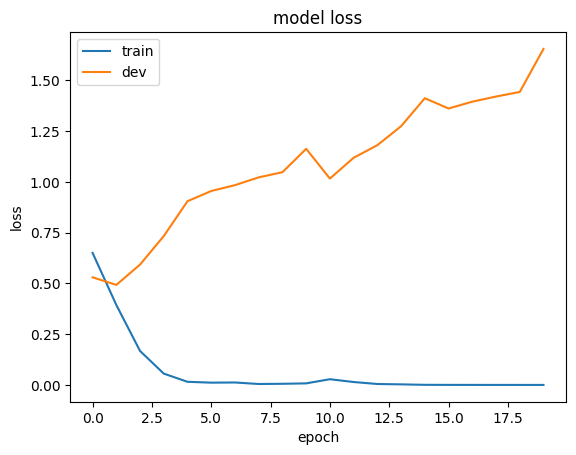

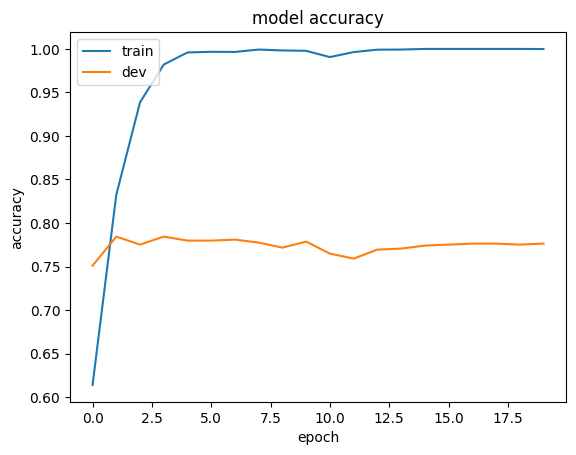

Loss:  1.5274473594349207
Accuracy:  0.7830862163646348


In [10]:
plot_history(history)

test_loss, test_acc = evaluate(model, test_loader)
print('Loss: ', test_loss)
print('Accuracy: ', test_acc)

Let's early stop the training

In [11]:
def train_loop(model, optimizer, epochs, patience=None, monitor="dev_acc"):

    # train mode for model
    model.train()

    history = {"loss": [], "dev_loss": [], "acc": [], "dev_acc": []}
    t0 = time.time()
    t_prev = t0

    # early stopping state
    best_metric = None
    patience_left = patience

    # perform the loop
    for epoch in range(epochs):
        total_loss, correct, total = 0, 0, 0
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            # zero gradients
            optimizer.zero_grad()

            # forward pass
            probs, loss = model(xb, yb)

            # backward pass
            loss.backward()

            # optimizer step
            optimizer.step()

            # compute metrics
            total_loss += loss.item() * xb.size(0)
            total += yb.size(0)
            with torch.no_grad():
                preds = (probs > 0.5).float()
                correct += (preds == yb).sum().item()

        loss = total_loss / total
        acc = correct / total

        # Evaluation
        dev_loss, dev_acc = evaluate(model, dev_loader)

        # Store info
        history["loss"].append(loss)
        history["dev_loss"].append(dev_loss)
        history["acc"].append(acc)
        history["dev_acc"].append(dev_acc)

        # Logging
        t = time.time()
        print(
            f"Epoch {epoch+1}/{epochs} - "
            f"Train loss: {loss:.4f} - "
            f"Train acc: {acc:.4f} - "
            f"Dev loss: {dev_loss:.4f} - "
            f"Dev acc: {dev_acc:.4f} - "
            f"Time: {(t - t_prev)*1000:.2f}ms"
        )

        # Early stopping update
        if patience:
            current = history[monitor][-1]
            if best_metric is None:
                best_metric = current
            improved = (current >= best_metric) if monitor == "dev_acc" else (current <= best_metric)
            if improved:
                best_metric = current
                patience_left = patience
            else:
                patience_left -= 1
            if patience_left <= 0:
                print("Early stopping triggered")
                break

        # Updates
        t_prev = t

    print(f"Total training time: {t-t0}")
    return history

In [12]:
# hyperparameters
learning_rate = 0.0100
batch_size = 128
embedding_size = 128
lstm_hidden_size = 128
epochs = 20

# data loaders
train_loader, dev_loader, test_loader = get_data_loaders(batch_size)

# model
model = LSTMClassifier(vocab_size=tokenizer.num_words, embedding_dim=embedding_size, hidden_dim=lstm_hidden_size).to(device)

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# execute the train loop
history_es = train_loop(model, optimizer, epochs, patience=1, monitor="dev_acc")

Epoch 1/20 - Train loss: 0.6520 - Train acc: 0.6149 - Dev loss: 0.6022 - Dev acc: 0.6663 - Time: 362.70ms
Epoch 2/20 - Train loss: 0.4014 - Train acc: 0.8273 - Dev loss: 0.4990 - Dev acc: 0.7867 - Time: 351.29ms
Epoch 3/20 - Train loss: 0.1663 - Train acc: 0.9373 - Dev loss: 0.6463 - Dev acc: 0.7752 - Time: 366.29ms
Early stopping triggered
Total training time: 1.080289363861084


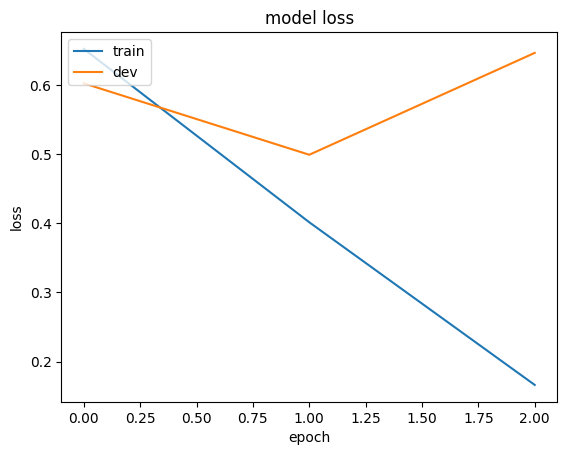

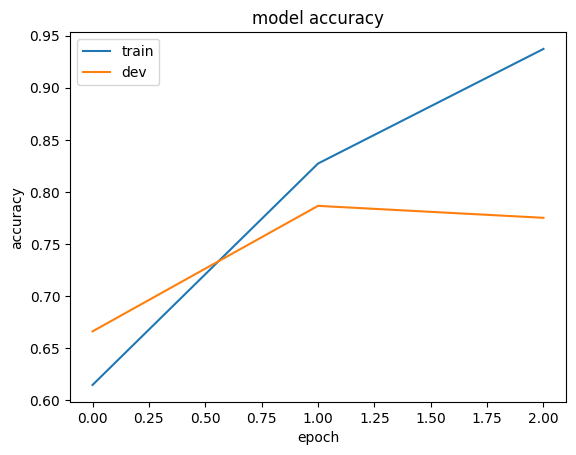

Loss:  0.5914644000623202
Accuracy:  0.7775947281713345


In [13]:
plot_history(history_es)

test_loss, test_acc = evaluate(model, test_loader)
print('Loss: ', test_loss)
print('Accuracy: ', test_acc)

### Exercise 1

- Try different embedding sizes and number of LSTM units. Do you see any differences in loss and accuracy curves? What happens very small embedding size (e.g ```embedding_size = 8```) or LSTM units (e.g ```units = 16```)? And what happens when we do the opposite thing?

- __Hint:__ Plotting original model's loss curve and your choice's curve will help you analysing the differences.

- __Hint__: Experiments take longer than in the previous labs (model complexity has increase, as well as the vocabulary size), you can increase ```batch_size``` in order to speed up the experiments.

__Answer__: Having large amount of training data with LSTM models (deep learning models in general) tend to improve results using bigger sizes. However, it is also a good regularization to reduce model size.


In [14]:
# hyperparameters
learning_rate = 0.0100
batch_size = 128
embedding_size = 8
lstm_hidden_size = 128
epochs = 20

# data loaders
train_loader, dev_loader, test_loader = get_data_loaders(batch_size)

# model
model = LSTMClassifier(vocab_size=tokenizer.num_words, embedding_dim=embedding_size, hidden_dim=lstm_hidden_size).to(device)

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# execute the train loop
small_emb_history = train_loop(model, optimizer, epochs)

Epoch 1/20 - Train loss: 0.6933 - Train acc: 0.5280 - Dev loss: 0.6865 - Dev acc: 0.5550 - Time: 663.97ms
Epoch 2/20 - Train loss: 0.6477 - Train acc: 0.6270 - Dev loss: 0.6216 - Dev acc: 0.6743 - Time: 692.94ms
Epoch 3/20 - Train loss: 0.5078 - Train acc: 0.7605 - Dev loss: 0.5817 - Dev acc: 0.6984 - Time: 1039.03ms
Epoch 4/20 - Train loss: 0.3676 - Train acc: 0.8477 - Dev loss: 0.6019 - Dev acc: 0.7374 - Time: 1240.78ms
Epoch 5/20 - Train loss: 0.2659 - Train acc: 0.8996 - Dev loss: 0.5808 - Dev acc: 0.7580 - Time: 1369.12ms
Epoch 6/20 - Train loss: 0.1758 - Train acc: 0.9402 - Dev loss: 0.6545 - Dev acc: 0.7454 - Time: 1177.85ms
Epoch 7/20 - Train loss: 0.1302 - Train acc: 0.9564 - Dev loss: 0.7760 - Dev acc: 0.7580 - Time: 844.96ms
Epoch 8/20 - Train loss: 0.0762 - Train acc: 0.9786 - Dev loss: 0.9730 - Dev acc: 0.7580 - Time: 599.21ms
Epoch 9/20 - Train loss: 0.0581 - Train acc: 0.9824 - Dev loss: 0.9685 - Dev acc: 0.7569 - Time: 552.32ms
Epoch 10/20 - Train loss: 0.0327 - Train a

In [15]:
# hyperparameters
learning_rate = 0.0100
batch_size = 128
embedding_size = 128
lstm_hidden_size = 16
epochs = 20

# data loaders
train_loader, dev_loader, test_loader = get_data_loaders(batch_size)

# model
model = LSTMClassifier(vocab_size=tokenizer.num_words, embedding_dim=embedding_size, hidden_dim=lstm_hidden_size).to(device)

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# execute the train loop
small_units_history = train_loop(model, optimizer, epochs)

Epoch 1/20 - Train loss: 0.6760 - Train acc: 0.5666 - Dev loss: 0.6180 - Dev acc: 0.6594 - Time: 356.87ms
Epoch 2/20 - Train loss: 0.4573 - Train acc: 0.7967 - Dev loss: 0.5438 - Dev acc: 0.7466 - Time: 367.02ms
Epoch 3/20 - Train loss: 0.2136 - Train acc: 0.9195 - Dev loss: 0.5714 - Dev acc: 0.7683 - Time: 347.76ms
Epoch 4/20 - Train loss: 0.1029 - Train acc: 0.9642 - Dev loss: 0.6592 - Dev acc: 0.7821 - Time: 372.71ms
Epoch 5/20 - Train loss: 0.0545 - Train acc: 0.9840 - Dev loss: 0.7145 - Dev acc: 0.7821 - Time: 349.22ms
Epoch 6/20 - Train loss: 0.0249 - Train acc: 0.9931 - Dev loss: 0.8635 - Dev acc: 0.7661 - Time: 358.10ms
Epoch 7/20 - Train loss: 0.0135 - Train acc: 0.9975 - Dev loss: 0.8905 - Dev acc: 0.7741 - Time: 355.98ms
Epoch 8/20 - Train loss: 0.0129 - Train acc: 0.9965 - Dev loss: 1.0183 - Dev acc: 0.7649 - Time: 347.16ms
Epoch 9/20 - Train loss: 0.0107 - Train acc: 0.9977 - Dev loss: 1.0765 - Dev acc: 0.7592 - Time: 346.52ms
Epoch 10/20 - Train loss: 0.0078 - Train acc: 

In [16]:
# hyperparameters
learning_rate = 0.0100
batch_size = 128
embedding_size = 512
lstm_hidden_size = 128
epochs = 20

# data loaders
train_loader, dev_loader, test_loader = get_data_loaders(batch_size)

# model
model = LSTMClassifier(vocab_size=tokenizer.num_words, embedding_dim=embedding_size, hidden_dim=lstm_hidden_size).to(device)

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# execute the train loop
big_emb_history = train_loop(model, optimizer, epochs)

Epoch 1/20 - Train loss: 0.6395 - Train acc: 0.6283 - Dev loss: 0.5246 - Dev acc: 0.7443 - Time: 460.44ms
Epoch 2/20 - Train loss: 0.3167 - Train acc: 0.8643 - Dev loss: 0.5197 - Dev acc: 0.7672 - Time: 462.68ms
Epoch 3/20 - Train loss: 0.0948 - Train acc: 0.9686 - Dev loss: 0.6699 - Dev acc: 0.7878 - Time: 440.27ms
Epoch 4/20 - Train loss: 0.0238 - Train acc: 0.9932 - Dev loss: 0.7922 - Dev acc: 0.7821 - Time: 459.45ms
Epoch 5/20 - Train loss: 0.0112 - Train acc: 0.9974 - Dev loss: 0.9226 - Dev acc: 0.7718 - Time: 434.46ms
Epoch 6/20 - Train loss: 0.0035 - Train acc: 0.9996 - Dev loss: 0.9845 - Dev acc: 0.7878 - Time: 451.48ms
Epoch 7/20 - Train loss: 0.0015 - Train acc: 0.9997 - Dev loss: 1.0841 - Dev acc: 0.7844 - Time: 436.74ms
Epoch 8/20 - Train loss: 0.0009 - Train acc: 0.9999 - Dev loss: 1.1357 - Dev acc: 0.7878 - Time: 448.45ms
Epoch 9/20 - Train loss: 0.0007 - Train acc: 0.9999 - Dev loss: 1.1858 - Dev acc: 0.7878 - Time: 447.20ms
Epoch 10/20 - Train loss: 0.0005 - Train acc: 

In [17]:
# hyperparameters
learning_rate = 0.0100
batch_size = 128
embedding_size = 128
lstm_hidden_size = 512
epochs = 20

# data loaders
train_loader, dev_loader, test_loader = get_data_loaders(batch_size)

# model
model = LSTMClassifier(vocab_size=tokenizer.num_words, embedding_dim=embedding_size, hidden_dim=lstm_hidden_size).to(device)

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# execute the train loop
big_units_history = train_loop(model, optimizer, epochs)

Epoch 1/20 - Train loss: 0.6982 - Train acc: 0.5298 - Dev loss: 0.6683 - Dev acc: 0.6009 - Time: 670.67ms
Epoch 2/20 - Train loss: 0.6178 - Train acc: 0.6575 - Dev loss: 0.5928 - Dev acc: 0.6972 - Time: 662.39ms
Epoch 3/20 - Train loss: 0.3802 - Train acc: 0.8319 - Dev loss: 0.5049 - Dev acc: 0.7683 - Time: 678.98ms
Epoch 4/20 - Train loss: 0.1856 - Train acc: 0.9308 - Dev loss: 0.6367 - Dev acc: 0.7706 - Time: 630.72ms
Epoch 5/20 - Train loss: 0.0802 - Train acc: 0.9734 - Dev loss: 0.7712 - Dev acc: 0.7626 - Time: 626.61ms
Epoch 6/20 - Train loss: 0.0251 - Train acc: 0.9925 - Dev loss: 0.9140 - Dev acc: 0.7615 - Time: 622.22ms
Epoch 7/20 - Train loss: 0.0162 - Train acc: 0.9954 - Dev loss: 0.9673 - Dev acc: 0.7775 - Time: 626.70ms
Epoch 8/20 - Train loss: 0.0032 - Train acc: 0.9994 - Dev loss: 1.1925 - Dev acc: 0.7741 - Time: 625.24ms
Epoch 9/20 - Train loss: 0.0019 - Train acc: 0.9996 - Dev loss: 1.2241 - Dev acc: 0.7729 - Time: 622.06ms
Epoch 10/20 - Train loss: 0.0012 - Train acc: 

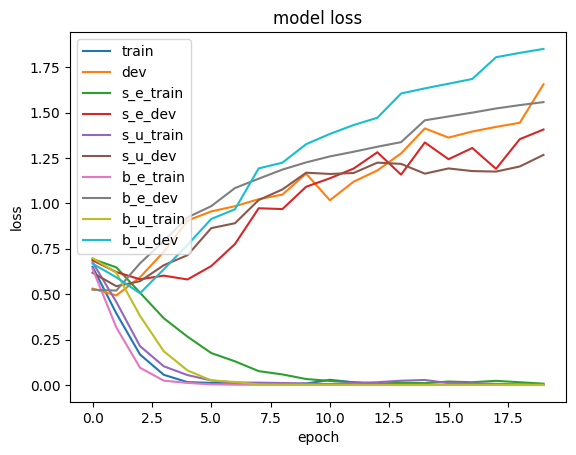

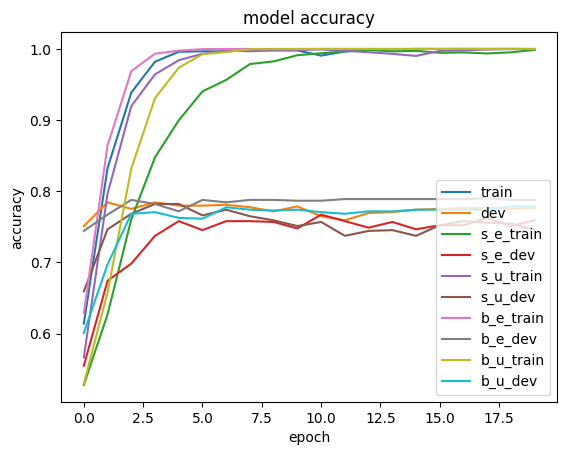

In [18]:
import matplotlib.pyplot as plt

# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['dev_loss'])

plt.plot(small_emb_history['loss'])
plt.plot(small_emb_history['dev_loss'])

plt.plot(small_units_history['loss'])
plt.plot(small_units_history['dev_loss'])

plt.plot(big_emb_history['loss'])
plt.plot(big_emb_history['dev_loss'])

plt.plot(big_units_history['loss'])
plt.plot(big_units_history['dev_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev', 's_e_train', 's_e_dev', 's_u_train', 's_u_dev', 'b_e_train', 'b_e_dev', 'b_u_train', 'b_u_dev'], loc='upper left')
plt.show()

# summarize history for accuracy
plt.plot(history['acc'])
plt.plot(history['dev_acc'])

plt.plot(small_emb_history['acc'])
plt.plot(small_emb_history['dev_acc'])

plt.plot(small_units_history['acc'])
plt.plot(small_units_history['dev_acc'])

plt.plot(big_emb_history['acc'])
plt.plot(big_emb_history['dev_acc'])

plt.plot(big_units_history['acc'])
plt.plot(big_units_history['dev_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev', 's_e_train', 's_e_dev', 's_u_train', 's_u_dev', 'b_e_train', 'b_e_dev', 'b_u_train', 'b_u_dev'], loc='lower right')
plt.show()

Since our training set is small and we are using more complex layers, the model is overfitting. But here you have some insights:

**1. Number of Units**
- **More units (neurons)** → higher capacity to capture complex patterns in the data, but risk of overfitting.  
- **Fewer units** → can help to regularize, but may underfit complex data.  
- **Consideration:** The optimal number depends on the complexity of the task and the amount of training data available.

**2. Embedding Dimension**
- **Higher embedding dimensions** → can capture more semantic or structural information, but may overfit to training data.  
- **Lower embedding dimensions** → may generalize better, but can compress too much information, losing important details.  
- **Consideration:** The embedding dimension should balance expressiveness with the risk of overfitting.

**3. Scenarios and Trade-offs**

| Scenario                     | Pros                          | Cons                                  |
|-------------------------------|-------------------------------|--------------------------------------|
| Small units + small embeddings | Efficient, less overfitting; lower computational cost | May underfit complex patterns; limited expressiveness |
| Large units + small embeddings | Can learn complex patterns if data is simple | Limited input information; risk of overfitting wasted capacity |
| Small units + large embeddings | Can represent rich input features | Bottleneck due to insufficient processing capacity; may underutilize embeddings |
| Large units + large embeddings | Powerful, expressive; can capture complex patterns | Risk of overfitting; higher computational cost; slower training |

**4. Key Takeaways**
- The **number of units** determines the network’s capacity to process and transform information.  
- The **embedding dimension** determines how richly each entity is represented.  
- Balance is crucial: too small in either dimension leads to underfitting, too large can lead to overfitting and inefficiency.




### Exercise 2

- It is sometimes useful to stack several recurrent layers one after the other in order to increase the representational power of a network. How would you do it?

- __Hint:__ In PyTorch, you can stack multiple LSTM layers by setting the ```num_layers``` parameter in the ```nn.LSTM``` constructor. PyTorch LSTM layers automatically handle stacking internally:
  - Single layer LSTM returns the last hidden state $\rightarrow$ ```[batch_size, hidden_size]```
  - Multi-layer LSTM returns the last hidden state from the top layer $\rightarrow$ ```[batch_size, hidden_size]```
  - The ```num_layers``` parameter controls how many LSTM layers are stacked on top of each other
  
- Unlike Keras, PyTorch doesn't have a ```return_sequences``` parameter - the LSTM always returns the final hidden state for classification tasks.

In [19]:
class LSTMClassifierStacked(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes=1, pad_idx=0, num_layers=2):
        super().__init__()
        self.pad_idx = pad_idx
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=self.pad_idx)
        self.lstm = nn.LSTM(input_size=embedding_dim,
                            hidden_size=hidden_dim,
                            num_layers=num_layers,
                            batch_first=True)
        self.classifier = nn.Linear(hidden_dim, num_classes)
        self.sigmoid = nn.Sigmoid()
        self.criterion = nn.BCELoss()

    def forward(self, input_ids, targets=None):
        lengths = (input_ids != 0).sum(dim=1).cpu()     # move to CPU for pack_padded_sequence
        embeds = self.embedding(input_ids)              # [batch, seq, emb]
        packed = nn.utils.rnn.pack_padded_sequence(
            embeds, lengths, batch_first=True, enforce_sorted=False
        )
        out, (h_n, c_n) = self.lstm(packed)
        # for single-layer uni-directional:
        last = h_n[-1]                                  # [batch, hidden]
        logits = self.classifier(last)                  # [batch, 1]
        probs = self.sigmoid(logits)
        if targets is not None:
            loss = self.criterion(probs, targets)
        else:
            loss = None
        return probs, loss

In [20]:
# hyperparameters
learning_rate = 0.0100
batch_size = 128
embedding_size = 128
lstm_hidden_size = 128
epochs = 10
num_layers = 2

# data loaders
train_loader, dev_loader, test_loader = get_data_loaders(batch_size)

# model
model = LSTMClassifierStacked(
    vocab_size=tokenizer.num_words,
    embedding_dim=embedding_size,
    hidden_dim=lstm_hidden_size,
    num_layers=num_layers,
    ).to(device)

# optimizer
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate) # tray a different optimizer than Adam

# execute the train loop
history = train_loop(model, optimizer, epochs)

Epoch 1/10 - Train loss: 0.7776 - Train acc: 0.5040 - Dev loss: 0.8652 - Dev acc: 0.5126 - Time: 706.62ms
Epoch 2/10 - Train loss: 0.6534 - Train acc: 0.6159 - Dev loss: 0.5727 - Dev acc: 0.7099 - Time: 656.92ms
Epoch 3/10 - Train loss: 0.3950 - Train acc: 0.8295 - Dev loss: 0.5819 - Dev acc: 0.7431 - Time: 500.20ms
Epoch 4/10 - Train loss: 0.1836 - Train acc: 0.9308 - Dev loss: 0.6260 - Dev acc: 0.7810 - Time: 514.34ms
Epoch 5/10 - Train loss: 0.0682 - Train acc: 0.9762 - Dev loss: 0.8092 - Dev acc: 0.7454 - Time: 507.23ms
Epoch 6/10 - Train loss: 0.0247 - Train acc: 0.9929 - Dev loss: 1.1396 - Dev acc: 0.7683 - Time: 485.83ms
Epoch 7/10 - Train loss: 0.0301 - Train acc: 0.9896 - Dev loss: 1.0122 - Dev acc: 0.7489 - Time: 495.71ms
Epoch 8/10 - Train loss: 0.0275 - Train acc: 0.9905 - Dev loss: 1.0698 - Dev acc: 0.7649 - Time: 493.82ms
Epoch 9/10 - Train loss: 0.0071 - Train acc: 0.9981 - Dev loss: 1.2412 - Dev acc: 0.7592 - Time: 507.02ms
Epoch 10/10 - Train loss: 0.0020 - Train acc: 

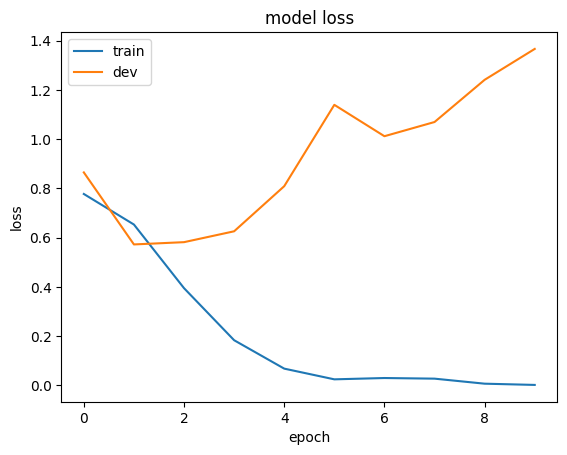

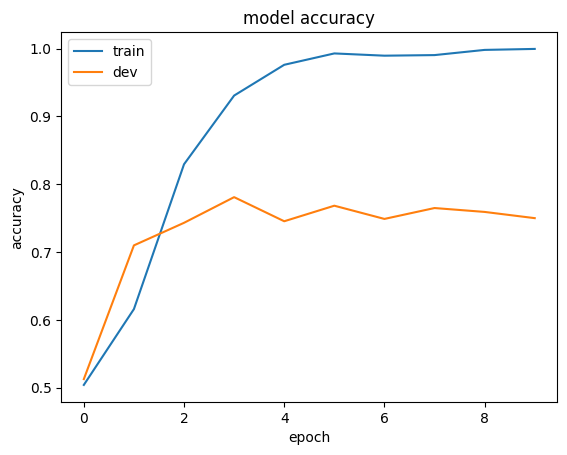

Loss:  1.3391393553353088
Accuracy:  0.7605711147721033


In [21]:
plot_history(history)

test_loss, test_acc = evaluate(model, test_loader)
print('Loss: ', test_loss)
print('Accuracy: ', test_acc)

## 4. Second LSTM: Initialized with Glove

When the training set is not large enough usually it is a good idea to use precomputed word embeddings as we can add some external knowledge that it is very difficult to acquire from the training set.

### 4.1 Reading precomputed embeddings

In [22]:
def read(file, threshold=0, dim=50, word_index=None):
    max_words = 400000 if threshold <= 0 else min(threshold, 400000)

    embeddings = {}
    lines = file.read()
    file.close()
    lines = lines.decode('utf8')
    for line in lines.split('\n'):
        vec = line.split(' ')
        word = vec[0]
        coefs = np.asarray(vec[1:], dtype='float32')
        embeddings[word] = coefs

    matrix = np.zeros((max_words, dim))
    for word, i in word_index.items():
      embedding_vector = embeddings.get(word)
      if i < max_words:
        if embedding_vector is not None:
          # Words not found in embedding index will be all-zeros.
          matrix[i] = embedding_vector
    return matrix

In [23]:
import bz2

# Read input embeddings
glove_home = 'drive/My Drive/Colab Notebooks/dl4nlp_summer_labs/data/word-embeddings/'
embsfile = bz2.open(glove_home + 'glove.6B.50d.txt.bz2')
embedding_matrix = read(embsfile, threshold=max_words+1, word_index=tokenizer.word_index)

print(embedding_matrix.shape)

(10001, 50)


### 4.2 Build LSTM based model

We will be using the same architecture as before. Only difference is that now we are going to use an ```embedding_size``` of 50, and the model will be compiled later (after we load the Glove embeddings).

In [24]:
# hyperparameters
learning_rate = 0.0100
batch_size = 128
embedding_size = 50
lstm_hidden_size = 128
epochs = 10

# data loaders
train_loader, dev_loader, test_loader = get_data_loaders(batch_size)

# model
model = LSTMClassifier(vocab_size=tokenizer.num_words, embedding_dim=embedding_size, hidden_dim=lstm_hidden_size).to(device)

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### 4.3 Load precomputed weights

Once we created the embedding matrix (in Section 4.1) in the correct format, we can easily load it into the Embedding layer. Remember that the matrix is of shape ```[max_words, embedding_size]```, where each entry ```i``` contains the embedding vector of the word of index ```i```, created with the tokenizer. Note that the index 0 is not supposed to stand for any word or token.

In PyTorch, we can access the embedding layer directly as ```model.embedding``` and initialize its weights using the ```copy_()``` method. We convert the numpy array to a PyTorch tensor and copy it to the embedding layer's weight parameter.

In addition we can freeze the weights so that we avoid updating during training and avoid forgetting what they already know. This is done by setting the ```requires_grad``` attribute of the embedding parameters to ```False```.

In [25]:
# Load weights
with torch.no_grad():
    emb_tensor = torch.tensor(embedding_matrix, dtype=torch.float32, device=device)
    emb_tensor = emb_tensor[:max_words]
    model.embedding.weight.copy_(emb_tensor)

# Freeze embedding layer (non trainable)
for param in model.embedding.parameters():
    param.requires_grad = False

### 4.4. Train and evaluate

Training and evaluation is done as in previous models. First we need to compile it (loss, optimizer and evaluation metric are indicated), then fit the model with the training data.

In [26]:
# execute the train loop
history = train_loop(model, optimizer, epochs)

Epoch 1/10 - Train loss: 0.5935 - Train acc: 0.6717 - Dev loss: 0.6242 - Dev acc: 0.6778 - Time: 368.06ms
Epoch 2/10 - Train loss: 0.5403 - Train acc: 0.7338 - Dev loss: 0.5073 - Dev acc: 0.7592 - Time: 302.94ms
Epoch 3/10 - Train loss: 0.4749 - Train acc: 0.7741 - Dev loss: 0.4853 - Dev acc: 0.7672 - Time: 311.46ms
Epoch 4/10 - Train loss: 0.4254 - Train acc: 0.8012 - Dev loss: 0.4900 - Dev acc: 0.7683 - Time: 313.83ms
Epoch 5/10 - Train loss: 0.3836 - Train acc: 0.8319 - Dev loss: 0.4520 - Dev acc: 0.8016 - Time: 310.76ms
Epoch 6/10 - Train loss: 0.3105 - Train acc: 0.8588 - Dev loss: 0.4851 - Dev acc: 0.7856 - Time: 308.15ms
Epoch 7/10 - Train loss: 0.2452 - Train acc: 0.8970 - Dev loss: 0.4995 - Dev acc: 0.8108 - Time: 301.98ms
Epoch 8/10 - Train loss: 0.1997 - Train acc: 0.9185 - Dev loss: 0.5588 - Dev acc: 0.7626 - Time: 308.17ms
Epoch 9/10 - Train loss: 0.1588 - Train acc: 0.9386 - Dev loss: 0.5902 - Dev acc: 0.8016 - Time: 305.84ms
Epoch 10/10 - Train loss: 0.1076 - Train acc: 

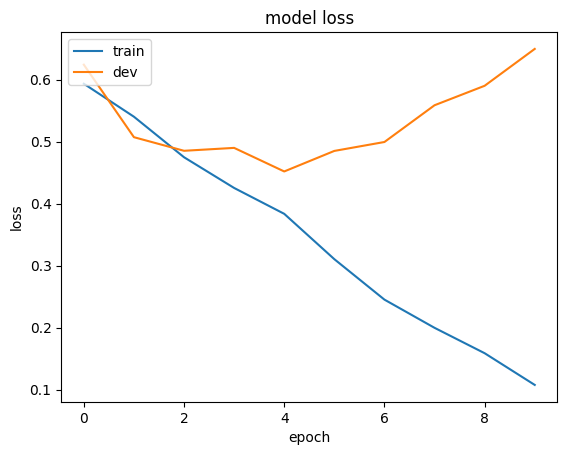

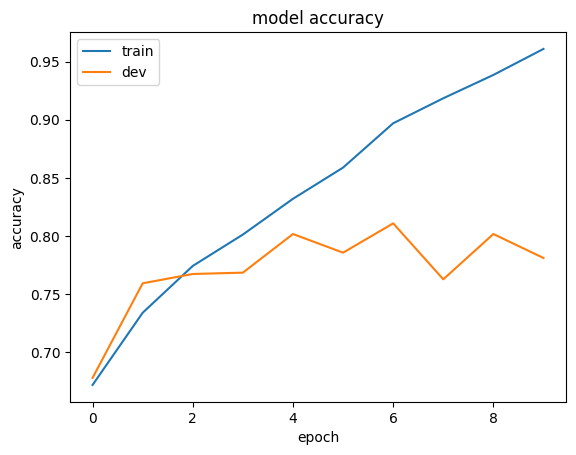

Loss:  0.7137550443230848
Accuracy:  0.7781438769906645


In [27]:
plot_history(history)

test_loss, test_acc = evaluate(model, test_loader)
print('Loss: ', test_loss)
print('Accuracy: ', test_acc)

The model does not show any improvements compared to models of the previous section. The reason for that can be  many, for example:
  - Vocabulary size is not big enough so we can expect many unknown word when encoding the sentence (not checked).
  - Maximum sequence length might be too small so we are leaving out some important information (not checked).
  - Training size is not too large, which in those cases simpler model usually perform better (due to the overfitting).

### Exercise 3

- In previous lab session we learn different techniques to avoid overfitting the model. In this case ```Dropout``` seems promising. Try adding a drop-out layer in the LSTM-based model.


### Exercise 4
- Another technique to fight overfitting is to reduce model size. Gated Recurrent Units (```GRU```) are a simpler version of the LSTMs. They have a smaller number of units. Try learning a new model based on GRU layers.

- __Hint__: In PyTorch, you can use ```nn.GRU``` instead of ```nn.LSTM```. The API is very similar to LSTM, but GRU has fewer parameters and is computationally more efficient. Check the PyTorch documentation for GRU: https://pytorch.org/docs/stable/generated/torch.nn.GRU.html
    

In [28]:
class LSTMClassifierWithDropout(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes=1, pad_idx=0, dropout_p=0.0):
        super().__init__()
        self.pad_idx = pad_idx
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=self.pad_idx)
        self.lstm = nn.LSTM(input_size=embedding_dim,
                            hidden_size=hidden_dim,
                            num_layers=num_layers,
                            batch_first=True)
        self.dropout = nn.Dropout(p=dropout_p)
        self.classifier = nn.Linear(hidden_dim, num_classes)
        self.sigmoid = nn.Sigmoid()
        self.criterion = nn.BCELoss()

    def forward(self, input_ids, targets=None):
        lengths = (input_ids != 0).sum(dim=1).cpu()     # move to CPU for pack_padded_sequence
        embeds = self.embedding(input_ids)              # [batch, seq, emb]
        packed = nn.utils.rnn.pack_padded_sequence(
            embeds, lengths, batch_first=True, enforce_sorted=False
        )
        out, (h_n, c_n) = self.lstm(packed)
        # for single-layer uni-directional:
        last = h_n[-1]                                  # [batch, hidden]
        last = self.dropout(last)
        logits = self.classifier(last)                  # [batch, 1]
        probs = self.sigmoid(logits)
        if targets is not None:
            loss = self.criterion(probs, targets)
        else:
            loss = None
        return probs, loss

In [29]:
# hyperparameters
learning_rate = 0.0100
batch_size = 128
embedding_size = 128
lstm_hidden_size = 16
epochs = 10
dropout_p = 0.5

# data loaders
train_loader, dev_loader, test_loader = get_data_loaders(batch_size)

# model
model = LSTMClassifierWithDropout(
    vocab_size=tokenizer.num_words,
    embedding_dim=embedding_size,
    hidden_dim=lstm_hidden_size,
    dropout_p=dropout_p,
    ).to(device)

# optimizer
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate) # tray a different optimizer than Adam

# execute the train loop
history = train_loop(model, optimizer, epochs)

Epoch 1/10 - Train loss: 0.6578 - Train acc: 0.6198 - Dev loss: 0.6063 - Dev acc: 0.6823 - Time: 695.58ms
Epoch 2/10 - Train loss: 0.4267 - Train acc: 0.8217 - Dev loss: 0.5400 - Dev acc: 0.7454 - Time: 685.20ms
Epoch 3/10 - Train loss: 0.2215 - Train acc: 0.9241 - Dev loss: 0.6343 - Dev acc: 0.7489 - Time: 669.54ms
Epoch 4/10 - Train loss: 0.1067 - Train acc: 0.9652 - Dev loss: 0.8259 - Dev acc: 0.7477 - Time: 744.22ms
Epoch 5/10 - Train loss: 0.0520 - Train acc: 0.9864 - Dev loss: 1.1010 - Dev acc: 0.7546 - Time: 612.15ms
Epoch 6/10 - Train loss: 0.0362 - Train acc: 0.9899 - Dev loss: 1.0228 - Dev acc: 0.7454 - Time: 510.67ms
Epoch 7/10 - Train loss: 0.0187 - Train acc: 0.9945 - Dev loss: 1.2762 - Dev acc: 0.7557 - Time: 525.75ms
Epoch 8/10 - Train loss: 0.0183 - Train acc: 0.9958 - Dev loss: 1.5353 - Dev acc: 0.7546 - Time: 508.53ms
Epoch 9/10 - Train loss: 0.0263 - Train acc: 0.9926 - Dev loss: 1.2932 - Dev acc: 0.7511 - Time: 534.30ms
Epoch 10/10 - Train loss: 0.0215 - Train acc: 

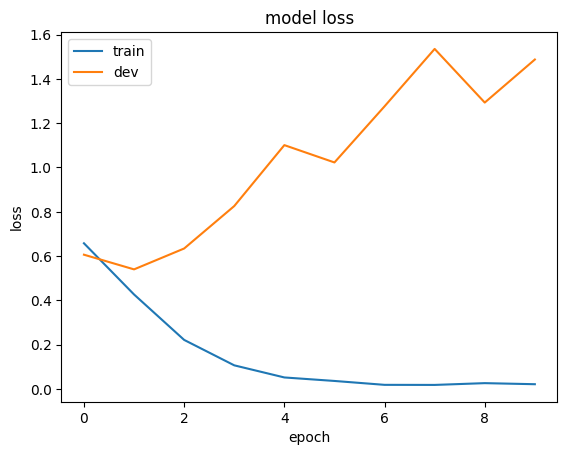

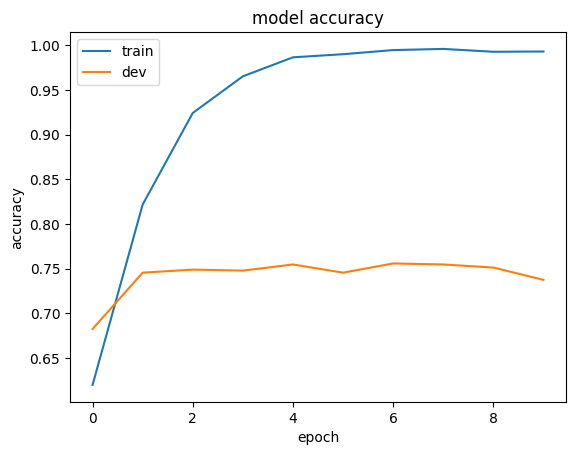

Loss:  1.3039012107791512
Accuracy:  0.7616694124107634


In [30]:
plot_history(history)

test_loss, test_acc = evaluate(model, test_loader)
print('Loss: ', test_loss)
print('Accuracy: ', test_acc)

## 5. Bidirectional LSTMs

Another well-known architecture is the bidirectional RNN. It is an extension of the regular RNN and usually offers a really good performance. Nowadays it is a standard architecture in NLP.

Note that RNNs (LSTMs and GRUs in a lesser degree) are dependent of the order and tend to remember the last words they have seen. A solution to this is to read the sentence from left-to-right and right-to-left, which can be implemented with bidirectional LSTMs.

In PyTorch, bidirectional LSTMs are implemented by setting ```bidirectional=True``` in the ```nn.LSTM``` constructor. This creates two separate LSTM layers that process the sequence in opposite directions, and their outputs are concatenated together.


In [31]:
class LSTMClassifierBiDir(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes=1, pad_idx=0):
        super().__init__()
        self.pad_idx = pad_idx
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=self.pad_idx)
        self.lstm = nn.LSTM(input_size=embedding_dim,
                            hidden_size=hidden_dim,
                            batch_first=True,
                            bidirectional=True)
        self.classifier = nn.Linear(hidden_dim * 2, num_classes) # 2 * hidden_dim (bidirectional output)
        self.sigmoid = nn.Sigmoid()
        self.criterion = nn.BCELoss()

    def forward(self, input_ids, targets=None):
        lengths = (input_ids != 0).sum(dim=1).cpu()     # move to CPU for pack_padded_sequence
        embeds = self.embedding(input_ids)              # [batch, seq, emb]
        packed = nn.utils.rnn.pack_padded_sequence(
            embeds, lengths, batch_first=True, enforce_sorted=False
        )
        out, (h_n, c_n) = self.lstm(packed)
        # For bidirectional LSTM, h_n shape is [2, batch, hidden_dim]
        # Concatenate forward and backward final hidden states
        forward_hidden = h_n[0]                         # [batch, hidden_dim]
        backward_hidden = h_n[1]                        # [batch, hidden_dim]
        last = torch.cat([forward_hidden, backward_hidden], dim=1)
        logits = self.classifier(last)                  # [batch, 1]
        probs = self.sigmoid(logits)
        if targets is not None:
            loss = self.criterion(probs, targets)
        else:
            loss = None
        return probs, loss

In [32]:
# hyperparameters
learning_rate = 0.0100
batch_size = 128
embedding_size = 50
lstm_hidden_size = 128
epochs = 20

# data loaders
train_loader, dev_loader, test_loader = get_data_loaders(batch_size)

# model
model = LSTMClassifierBiDir(
    vocab_size=tokenizer.num_words,
    embedding_dim=embedding_size,
    hidden_dim=lstm_hidden_size,
    ).to(device)

# optimizer
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate) # tray a different optimizer than Adam

In [33]:
# Load weights
with torch.no_grad():
    emb_tensor = torch.tensor(embedding_matrix, dtype=torch.float32, device=device)
    emb_tensor = emb_tensor[:max_words]
    model.embedding.weight.copy_(emb_tensor)

# Freeze embedding layer (non trainable)
for param in model.embedding.parameters():
    param.requires_grad = False

In [34]:
# execute the train loop
history = train_loop(model, optimizer, epochs)

Epoch 1/20 - Train loss: 0.9382 - Train acc: 0.5286 - Dev loss: 0.8059 - Dev acc: 0.4943 - Time: 537.59ms
Epoch 2/20 - Train loss: 0.6379 - Train acc: 0.6221 - Dev loss: 0.6999 - Dev acc: 0.5596 - Time: 496.01ms
Epoch 3/20 - Train loss: 0.5362 - Train acc: 0.7269 - Dev loss: 0.7120 - Dev acc: 0.6135 - Time: 479.76ms
Epoch 4/20 - Train loss: 0.4870 - Train acc: 0.7627 - Dev loss: 0.8326 - Dev acc: 0.5688 - Time: 493.84ms
Epoch 5/20 - Train loss: 0.4535 - Train acc: 0.7874 - Dev loss: 1.0558 - Dev acc: 0.6227 - Time: 478.79ms
Epoch 6/20 - Train loss: 0.4168 - Train acc: 0.8091 - Dev loss: 0.5088 - Dev acc: 0.7523 - Time: 455.03ms
Epoch 7/20 - Train loss: 0.3483 - Train acc: 0.8439 - Dev loss: 0.5244 - Dev acc: 0.7706 - Time: 462.34ms
Epoch 8/20 - Train loss: 0.2995 - Train acc: 0.8708 - Dev loss: 0.5382 - Dev acc: 0.7546 - Time: 433.26ms
Epoch 9/20 - Train loss: 0.2395 - Train acc: 0.8988 - Dev loss: 0.6494 - Dev acc: 0.7408 - Time: 456.56ms
Epoch 10/20 - Train loss: 0.1938 - Train acc: 

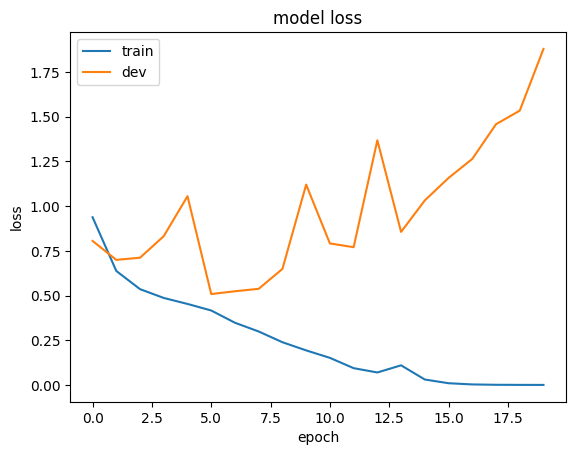

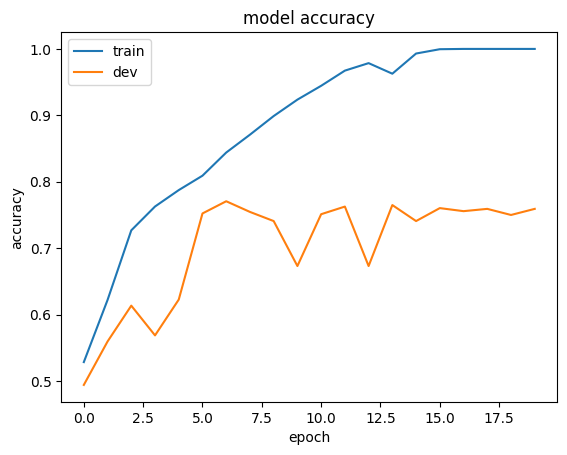

Loss:  1.6571710534242403
Accuracy:  0.7605711147721033


In [35]:
plot_history(history)

test_loss, test_acc = evaluate(model, test_loader)
print('Loss: ', test_loss)
print('Accuracy: ', test_acc)

## 6. Improve your model

### Exercise 5
It would be great if you could try improving the model by exploring different hyperparameters. For example,  you can explore the following ones:
- Learning Rates of the optimizer.
- Combination of different regularization techniques.
- Vocabulary size (using larger set of words).
- Number of units in the recurrent layer.
- Number of stacked recurrent layers.
- Type of recurrent layer: LSTM vs GRU vs BiLSTM
- Number of training epochs (if you are using early stopping, set patience).


In [38]:
# hyperparams for the tokenizer
max_words = 10000
max_seq = 40

# Build tokenizer on training texts only
tokenizer = TorchTokenizer(num_words=max_words, oov_token="<unk>")
tokenizer.fit_on_texts(train_texts)

# Convert to sequences
train_sequences = tokenizer.texts_to_sequences(train_texts)
dev_sequences = tokenizer.texts_to_sequences(dev_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

# Pad
x_train = pad_sequences(train_sequences, maxlen=max_seq)
x_dev = pad_sequences(dev_sequences, maxlen=max_seq)
x_test = pad_sequences(test_sequences, maxlen=max_seq)

# Labels
y_train = torch.tensor(train_labels, dtype=torch.float32).unsqueeze(1)
y_dev = torch.tensor(dev_labels, dtype=torch.float32).unsqueeze(1)
y_test = torch.tensor(test_labels, dtype=torch.float32).unsqueeze(1)

# Create datasets using PyTorch's TensorDataset
train_dataset = TensorDataset(x_train, y_train)
dev_dataset = TensorDataset(x_dev, y_dev)
test_dataset = TensorDataset(x_test, y_test)

print('Shape of the training set (nb_examples, seq_len):', x_train.shape)
print('Shape of the validation set (nb_examples, seq_len):', x_dev.shape)
print('Shape of the test set (nb_examples, seq_len):', x_test.shape)

# Print some examples
print()
print('TEXT: {}\nPADDED: {}'.format(train_texts.iloc[0], x_train[0]))
print()
print('TEXT: {}\nPADDED: {}'.format(train_texts.iloc[1], x_train[1]))

Shape of the training set (nb_examples, seq_len): torch.Size([6920, 40])
Shape of the validation set (nb_examples, seq_len): torch.Size([872, 40])
Shape of the test set (nb_examples, seq_len): torch.Size([1821, 40])

TEXT: This rush to profits has created a predictably efficient piece of business notable largely for its overwhelming creepiness , for an eagerness to create images you wish you had n't seen , which , in this day and age , is of course the point .
PADDED: tensor([  17, 1827,    6, 7190,   29,  935,    3, 1828, 4930,  249,    5, 1200,
        2979, 1201,   19,   20, 2980, 4931,   19,   18, 7191,    6,  874,  536,
          21, 1010,   21,  207,   24,   22,  200,   79,   11,   17,  280,    4,
         342,    7,    5, 1317])

TEXT: Takes a clunky TV-movie approach to detailing a chapter in the life of the celebrated Irish playwright , poet and drinker .
PADDED: tensor([ 234,    3, 3709,  383,   16,  763,    6, 4932,    3, 7192,   11,    2,
          80,    5,    2, 4933, 248

In [41]:
import bz2

# Read input embeddings
glove_home = 'drive/My Drive/Colab Notebooks/dl4nlp_summer_labs/data/word-embeddings/'
embsfile = bz2.open(glove_home + 'glove.6B.50d.txt.bz2')
embedding_matrix = read(embsfile, threshold=max_words+1, word_index=tokenizer.word_index)

print(embedding_matrix.shape)

(10001, 50)


In [43]:
class LSTMClassifierComplete(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, dense_dim, num_classes=1, pad_idx=0, dropout_p=0.0, reg_weight=0.0):

        super().__init__()

        # store params
        self.pad_idx = pad_idx
        self.reg_weight = reg_weight

        # embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=self.pad_idx)

        # bidirectional LSTM
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            batch_first=True,
            bidirectional=True
        )
        self.dropout1 = nn.Dropout(p=dropout_p)

        # first dense layer with ReLU activation
        self.dense1 = nn.Linear(hidden_dim*2, dense_dim)  # hidden_dim*2 (bidirectional)
        self.relu = nn.ReLU()
        self.dropout2 = nn.Dropout(p=dropout_p)

        # final dense layer for classification
        self.classifier = nn.Linear(dense_dim, 1)
        self.sigmoid = nn.Sigmoid()
        self.criterion = nn.BCELoss()

    def l2_regularization(self, layer):
        if self.reg_weight > 0:
            return self.reg_weight * torch.sum(layer.weight ** 2)
        else:
            return 0.0

    def lstm_regularization(self):
        if self.reg_weight > 0:
            # LSTM has multiple weight matrices: weight_ih_l0, weight_hh_l0, weight_ih_l0_reverse, weight_hh_l0_reverse
            # regularize all of them
            total_reg = 0.0
            for name, param in self.lstm.named_parameters():
                if 'weight' in name:  # only regularize weights, not biases
                    total_reg += torch.sum(param ** 2)
            return self.reg_weight * total_reg
        else:
            return 0.0

    def forward(self, input_ids, targets=None):
        lengths = (input_ids != 0).sum(dim=1).cpu()
        embeds = self.embedding(input_ids)
        packed = nn.utils.rnn.pack_padded_sequence(embeds, lengths, batch_first=True, enforce_sorted=False)
        out, (h_n, c_n) = self.lstm(packed)

        # concatenate forward and backward hidden states
        forward_hidden = h_n[0]
        backward_hidden = h_n[1]
        last = torch.cat([forward_hidden, backward_hidden], dim=1)

        # apply dropout and dense layers
        last = self.dropout1(last)
        last = self.dense1(last)
        last = self.relu(last)
        last = self.dropout2(last)

        logits = self.classifier(last)
        probs = self.sigmoid(logits)

        if targets is not None:
            loss = self.criterion(probs, targets)
        else:
            loss = None

        if loss is not None and self.reg_weight > 0:
            # add L2 regularization from each layer
            l2_reg = (self.lstm_regularization() +
                     self.l2_regularization(self.dense1) +
                     self.l2_regularization(self.classifier))
            loss = loss + l2_reg

        return probs, loss

In [55]:
# hyperparameters
embedding_size = 50
lstm_hidden_size = 128
dense_hidden_size = 64
epochs = 100
batch_size = 32

lrs = [0.0001, 0.001, 0.01]
drs = [0.0, 0.2, 0.5]
regs = [0.0, 0.0001]
pretrained_embeddings = [True, False]

# data loaders
train_loader, dev_loader, test_loader = get_data_loaders(batch_size)

history = {}
for lr in lrs:
    for reg in regs:
        for dr in drs:
            for pe in pretrained_embeddings:

                # model
                model = LSTMClassifierComplete(
                    vocab_size=tokenizer.num_words,
                    embedding_dim=embedding_size,
                    hidden_dim=lstm_hidden_size,
                    dense_dim=dense_hidden_size,
                    dropout_p=dr,
                    reg_weight=reg,
                    ).to(device)

                # optimizer
                optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

                # Load weights
                with torch.no_grad():
                    emb_tensor = torch.tensor(embedding_matrix, dtype=torch.float32, device=device)
                    emb_tensor = emb_tensor[:max_words]
                    model.embedding.weight.copy_(emb_tensor)

                if not pe:
                  # Freeze embedding layer (non trainable)
                  for param in model.embedding.parameters():
                      param.requires_grad = False

                # execute the train loop
                history[f"lr{lr}-reg{reg}-dr{dr}-pe{pe}"] = train_loop(model, optimizer, epochs, patience=1, monitor="dev_acc")

Epoch 1/100 - Train loss: 1.0601 - Train acc: 0.5662 - Dev loss: 0.6840 - Dev acc: 0.5722 - Time: 1639.84ms
Epoch 2/100 - Train loss: 0.4283 - Train acc: 0.8075 - Dev loss: 0.5667 - Dev acc: 0.7511 - Time: 1616.67ms
Epoch 3/100 - Train loss: 0.1847 - Train acc: 0.9283 - Dev loss: 0.6874 - Dev acc: 0.7569 - Time: 1646.25ms
Epoch 4/100 - Train loss: 0.0736 - Train acc: 0.9741 - Dev loss: 0.8948 - Dev acc: 0.7466 - Time: 1634.46ms
Early stopping triggered
Total training time: 6.537227392196655
Epoch 1/100 - Train loss: 2.6439 - Train acc: 0.5623 - Dev loss: 0.5838 - Dev acc: 0.6892 - Time: 2004.92ms
Epoch 2/100 - Train loss: 0.5367 - Train acc: 0.7360 - Dev loss: 0.5321 - Dev acc: 0.7397 - Time: 1838.06ms
Epoch 3/100 - Train loss: 0.4727 - Train acc: 0.7764 - Dev loss: 0.4805 - Dev acc: 0.7695 - Time: 1485.44ms
Epoch 4/100 - Train loss: 0.4123 - Train acc: 0.8140 - Dev loss: 0.4903 - Dev acc: 0.7580 - Time: 1469.95ms
Early stopping triggered
Total training time: 6.798363447189331
Epoch 1/

In [56]:
best_epochs = []
accs = []
params_list = []
for params in history:
    params_list.append(params)
    index = np.argmax(history[params]['dev_acc'])
    best_epochs.append(index+1)
    accs.append(history[params]['dev_acc'][index])
pd.DataFrame(data={'params': params_list, 'best_epoch':best_epochs, 'acc':accs})

,params,best_epoch,acc
0,lr0.0001-reg0.0-dr0.0-peTrue,3,0.756881
1,lr0.0001-reg0.0-dr0.0-peFalse,3,0.769495
2,lr0.0001-reg0.0-dr0.2-peTrue,5,0.805046
3,lr0.0001-reg0.0-dr0.2-peFalse,5,0.764908
4,lr0.0001-reg0.0-dr0.5-peTrue,6,0.798165
5,lr0.0001-reg0.0-dr0.5-peFalse,4,0.767202
6,lr0.0001-reg0.0001-dr0.0-peTrue,1,0.805046
7,lr0.0001-reg0.0001-dr0.0-peFalse,4,0.778670
8,lr0.0001-reg0.0001-dr0.2-peTrue,2,0.806193
9,lr0.0001-reg0.0001-dr0.2-peFalse,7,0.791284
